<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [10]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

Mounted at /gdrive


In [11]:
%load_ext autoreload
%autoreload 2
from functions import *

np.random.seed(17)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the Data

In [12]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
48450,complete works vol 1,Aristotle,aristotle,"And this is true in every category, whether th...","And this is true in every category, whether th...",132,"and this is true in every category, whether th...","and this be true in every category , whether ...","['And', 'this', 'is', 'true', 'in', 'every', '..."
236307,being and time,Heidegger,phenomenology,But this existential interpretation is necessa...,But this existential interpretation is necessa...,284,but this existential interpretation is necessa...,but this existential interpretation be necess...,"['But', 'this', 'existential', 'interpretation..."
117613,search after truth,Malebranche,rationalism,"Rather it should become its judge and master, ...","Rather it should become its judge and master, ...",116,"rather it should become its judge and master, ...",rather -PRON- should become -PRON- judge and ...,"['Rather', 'it', 'should', 'become', 'its', 'j..."
72251,complete works vol 2,Aristotle,aristotle,"This sort of having, then, evidently we cannot...","This sort of having, then, evidently we cannot...",137,"this sort of having, then, evidently we cannot...","this sort of have , then , evidently -PRON- c...","['This', 'sort', 'of', 'having', ',', 'then', ..."
70656,complete works vol 2,Aristotle,aristotle,"Again, it will not be possible to construct a ...","Again, it will not be possible to construct a ...",67,"again, it will not be possible to construct a ...","again , -PRON- will not be possible to constr...","['Again', ',', 'it', 'will', 'not', 'be', 'pos..."


### Build a Baseline LSTM Model

In [13]:
# make the labels numerical
school_label_dict = {'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}
flipped_dict = {value:key for key, value in school_label_dict.items()}

x = df['sentence_str']
y = df['school'].apply(lambda x: school_label_dict[x])

x_train, x_test, y_train, y_test = train_test_split(x,y)

In [2]:
# get class weights
weights= compute_class_weight(
           'balanced',
            np.unique(y_train), 
            y_train)

weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

NameError: ignored

In [3]:
y_train_seq = to_categorical(y_train)
y_test_seq = to_categorical(y_test)

NameError: ignored

In [4]:
tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# check what to our max sequence length should be 
max(list(map(lambda x: len(x),[*train_sequences,*test_sequences])))

NameError: ignored

In [5]:
from google.colab import files

# save the tokenizer so we can use the model on new texts
tokenizer_pkl = open('baseline_tokenizer.pkl', 'wb')
pickle.dump(tokenizer, tokenizer_pkl)
files.download('baseline_tokenizer.pkl')
tokenizer_pkl.close()

NameError: ignored

In [6]:
# do the relevant padding
max_length = 450

x_train_seq = sequence.pad_sequences(train_sequences, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=max_length)

NameError: ignored

In [7]:
# check how many distinct words are in the corpus
len(tokenizer.index_word)

NameError: ignored

In [8]:
# set up callbacks
model_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP/checkpoints'

def set_early_stop(monitor='val_accuracy',patience=3, restore_best_weights=True,
                   min_delta=0.01, verbose=1):
  args = locals()
  return EarlyStopping(**args)

def set_checkpoint(monitor='val_accuracy',model_subfolder=model_path, verbose=0):
  filepath = model_subfolder+ "/NN_weights_epoch:{epoch:02d}_{"+monitor+":.4f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=verbose,
                                 save_best_only=True, mode='auto')
  return checkpoint

def list_callbacks(checkpoints=True, early_stopping=True, modeling_folder=model_path,
                   monitor_checkpoint='val_accuracy',monitor_stopping='val_accuracy',
                   min_delta=0.001, patience=3, ck_verbose=0, es_verbose=1, 
                   restore_best_weights=True):
  callbacks = []
  if checkpoints:
      callbacks.append(set_checkpoint(monitor=monitor_checkpoint,
                                      model_subfolder=modeling_folder,
                                      verbose=ck_verbose))

  if early_stopping:
      callbacks.append(set_early_stop(monitor=monitor_stopping, min_delta=min_delta,
                                      patience=patience,verbose=es_verbose,
                                      restore_best_weights=restore_best_weights))
  return callbacks

list_callbacks()

NameError: ignored

In [12]:
def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    # model.add(Dense(25, activation='relu'))
    # model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         21688576  
_________________________________________________________________
lstm (LSTM)                  (None, 50)                61400     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
Total params: 21,751,511
Trainable params: 21,751,511
Non-trainable params: 0
_________________________________________________________________


None

In [13]:
history = model.fit(x_train_seq, y_train_seq, epochs=10,
                    batch_size=256, validation_split=0.2,
                    callbacks=list_callbacks(),
                    class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 135s 170ms/step - loss: 1.7538 - accuracy: 0.3410 - val_loss: 0.9063 - val_accuracy: 0.7134
Epoch 2/10
760/760 [==============================] - 125s 164ms/step - loss: 0.9035 - accuracy: 0.7085 - val_loss: 0.7830 - val_accuracy: 0.7525
Epoch 3/10
760/760 [==============================] - 128s 168ms/step - loss: 0.7007 - accuracy: 0.7765 - val_loss: 0.7805 - val_accuracy: 0.7581
Epoch 4/10
760/760 [==============================] - 124s 163ms/step - loss: 0.5874 - accuracy: 0.8066 - val_loss: 0.8022 - val_accuracy: 0.7697
Epoch 5/10
760/760 [==============================] - 124s 164ms/step - loss: 0.5171 - accuracy: 0.8298 - val_loss: 0.8328 - val_accuracy: 0.7707
Epoch 6/10
760/760 [==============================] - 124s 164ms/step - loss: 0.4793 - accuracy: 0.8418 - val_loss: 0.8895 - val_accuracy: 0.7685
Epoch 7/10
760/760 [==============================] - 124s 164ms/step - loss: 0.4193 - accuracy: 0.8599 - val_loss: 0.9401 -

Not bad! We got a stronger model than the Bayesian models on our first try. Hopefully this can be improved with some more tweaking. First though, let's take a look at charts regarding our final result.

In [14]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

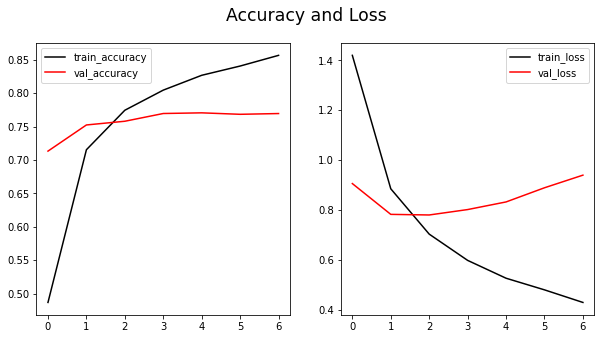

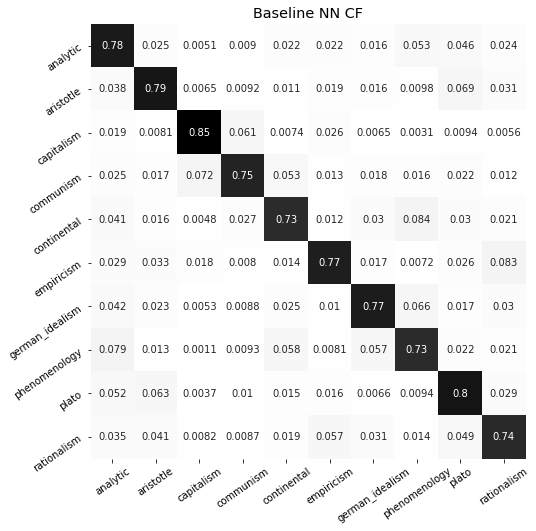




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     13307
           1       0.83      0.79      0.81     12168
           2       0.84      0.85      0.85      4467
           3       0.76      0.75      0.75      4477
           4       0.79      0.73      0.76      8565
           5       0.73      0.77      0.75      5114
           6       0.84      0.77      0.81     10454
           7       0.68      0.73      0.70      7288
           8       0.74      0.80      0.77      9526
           9       0.66      0.74      0.70      5618

    accuracy                           0.77     80984
   macro avg       0.77      0.77      0.77     80984
weighted avg       0.77      0.77      0.77     80984



In [15]:
summarize_model(history, test, preds, labels=flipped_dict, title='Baseline NN CF')

Seems good, though it did overfit towards the end. Neural nets seem like they might be the way to go - let's try some options out!



### Hyperparameter Tuning

#### Try Using GRU instead of LSTM

In [33]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# Trying out GRU
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(GRU(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         10850176  
_________________________________________________________________
gru (GRU)                    (None, 50)                27000     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                260       
Total params: 10,878,711
Trainable params: 10,878,711
Non-trainable params: 0
_________________________________________________________________


None

In [ ]:
GRU_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 81s 105ms/step - loss: 1.8865 - accuracy: 0.2915 - val_loss: 0.9937 - val_accuracy: 0.6802
Epoch 2/10
760/760 [==============================] - 80s 105ms/step - loss: 1.0399 - accuracy: 0.6597 - val_loss: 0.8145 - val_accuracy: 0.7424
Epoch 3/10
760/760 [==============================] - 79s 104ms/step - loss: 0.8234 - accuracy: 0.7386 - val_loss: 0.7898 - val_accuracy: 0.7504
Epoch 4/10
760/760 [==============================] - 77s 102ms/step - loss: 0.7134 - accuracy: 0.7749 - val_loss: 0.7820 - val_accuracy: 0.7591
Epoch 5/10
760/760 [==============================] - 78s 102ms/step - loss: 0.6389 - accuracy: 0.7968 - val_loss: 0.8195 - val_accuracy: 0.7589
Epoch 6/10
760/760 [==============================] - 78s 103ms/step - loss: 0.5759 - accuracy: 0.8163 - val_loss: 0.8455 - val_accuracy: 0.7602
Epoch 7/10
721/760 [===========================>..] - ETA: 3s - loss: 0.5321 - accuracy: 0.8289

KeyboardInterrupt: ignored

GRU seems to do just slightly worse than LSTM on this task. 

In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(GRU_history, test, preds, labels=flipped_dict, title='Triple Dense NN CF')

#### Bidirectional LSTM

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, tokenizer_name='bidirectional_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         10850176  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100)               71600     
_________________________________________________________________
dense_7 (Dense)              (None, 25)                2525      
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                260       
Total params: 10,924,561
Trainable params: 10,924,561
Non-trainable params: 0
_________________________________________________________________


None

In [ ]:
bidirectional_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 118s 150ms/step - loss: 1.8777 - accuracy: 0.2866 - val_loss: 0.9855 - val_accuracy: 0.6870
Epoch 2/10
760/760 [==============================] - 113s 149ms/step - loss: 0.9928 - accuracy: 0.6729 - val_loss: 0.8160 - val_accuracy: 0.7464
Epoch 3/10
760/760 [==============================] - 113s 149ms/step - loss: 0.7536 - accuracy: 0.7593 - val_loss: 0.7991 - val_accuracy: 0.7548
Epoch 4/10
760/760 [==============================] - 113s 149ms/step - loss: 0.6327 - accuracy: 0.7948 - val_loss: 0.8009 - val_accuracy: 0.7618
Epoch 5/10
760/760 [==============================] - 113s 149ms/step - loss: 0.5653 - accuracy: 0.8181 - val_loss: 0.8326 - val_accuracy: 0.7646
Epoch 6/10
760/760 [==============================] - 113s 149ms/step - loss: 0.5079 - accuracy: 0.8336 - val_loss: 0.8404 - val_accuracy: 0.7703
Epoch 7/10
760/760 [==============================] - 113s 149ms/step - loss: 0.4624 - accuracy: 0.8458 - val_loss: 0.9008 -

Looks good, more or less on par with the baseline unidirectional LSTM. 

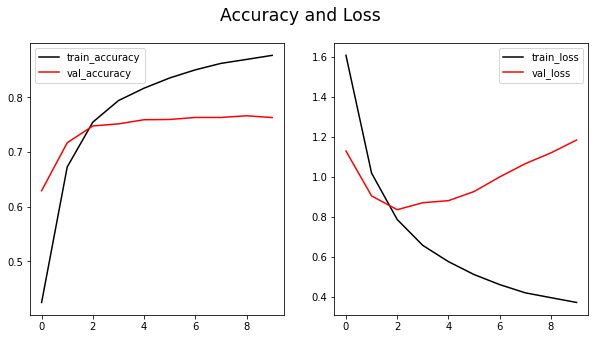

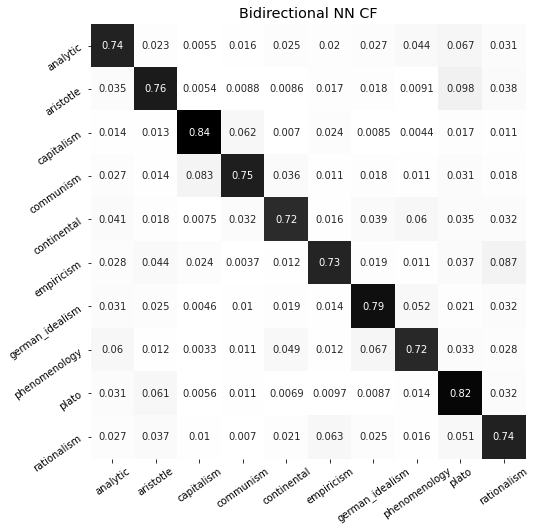




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.74      0.77     13292
           1       0.83      0.76      0.79     12254
           2       0.81      0.84      0.82      4573
           3       0.74      0.75      0.74      4559
           4       0.81      0.72      0.76      8246
           5       0.72      0.73      0.73      5085
           6       0.82      0.79      0.80     10330
           7       0.72      0.72      0.72      7243
           8       0.69      0.82      0.75      9668
           9       0.62      0.74      0.68      5734

    accuracy                           0.76     80984
   macro avg       0.76      0.76      0.76     80984
weighted avg       0.77      0.76      0.76     80984



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Bidirectional NN CF')

This printout could be the one we saw before. Still some overtraining - we probably don't need all 10 epochs. 

#### Multiple LSTM Layers 

Next, let's try training a model with multiple LSTM layers to see if that improves performance.

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y)

# commented out layers indicate past attempts
# none were particularly successful
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))
    # model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(LSTM(50, return_sequences=False))


    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

In [ ]:
multi_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Similar result again. It doesn't seem like more layers of LSTM is what we need to improve results.

In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Multiple LSTM NN CF')

More or less the same as past models. More layers don't seem to hurt (except when it comes to training time), but they don't seem to help much either. 

#### More LSTM Neurons

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_len=450)

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(100, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

In [ ]:
extra_LSTM_neurons_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=128, validation_split=0.2,
                                  callbacks=set_early_stop(),
                                  class_weight=weights_dict)

Epoch 1/10
1534/1534 [==============================] - 122s 79ms/step - loss: 1.6645 - accuracy: 0.4013 - val_loss: 0.8616 - val_accuracy: 0.7301
Epoch 2/10
1534/1534 [==============================] - 121s 79ms/step - loss: 0.8632 - accuracy: 0.7321 - val_loss: 0.7821 - val_accuracy: 0.7557
Epoch 3/10
1534/1534 [==============================] - 120s 78ms/step - loss: 0.6833 - accuracy: 0.7879 - val_loss: 0.8177 - val_accuracy: 0.7559
Epoch 4/10
1274/1534 [=======================>......] - ETA: 19s - loss: 0.5744 - accuracy: 0.8209

In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_LSTM_neurons_history, test, preds, labels=flipped_dict, title='Extra LSTM NN CF')

#### More Dense Layers

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         10048256  
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

None

In [ ]:
extra_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
761/761 [==============================] - 76s 98ms/step - loss: 2.0231 - accuracy: 0.2238 - val_loss: 1.2894 - val_accuracy: 0.5657
Epoch 2/20
761/761 [==============================] - 69s 91ms/step - loss: 1.3286 - accuracy: 0.5118 - val_loss: 1.0573 - val_accuracy: 0.6625
Epoch 3/20
761/761 [==============================] - 70s 92ms/step - loss: 1.1175 - accuracy: 0.6128 - val_loss: 0.9879 - val_accuracy: 0.6902
Epoch 4/20
761/761 [==============================] - 69s 91ms/step - loss: 0.9822 - accuracy: 0.6649 - val_loss: 0.9652 - val_accuracy: 0.7026
Epoch 5/20
761/761 [==============================] - 70s 92ms/step - loss: 0.8954 - accuracy: 0.6966 - val_loss: 0.9685 - val_accuracy: 0.7189
Epoch 6/20
761/761 [==============================] - 69s 91ms/step - loss: 0.8185 - accuracy: 0.7259 - val_loss: 0.9728 - val_accuracy: 0.7290
Epoch 7/20
761/761 [==============================] - 70s 91ms/step - loss: 0.7750 - accuracy: 0.7435 - val_loss: 1.0374 - val_accuracy:

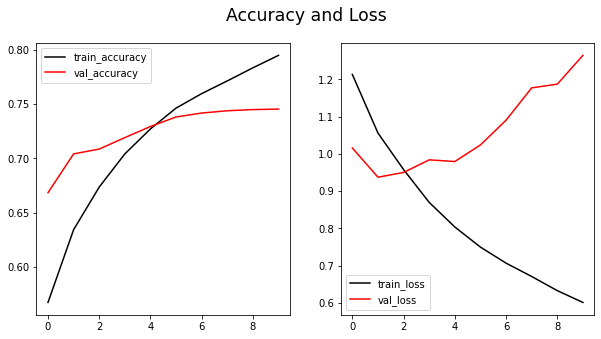

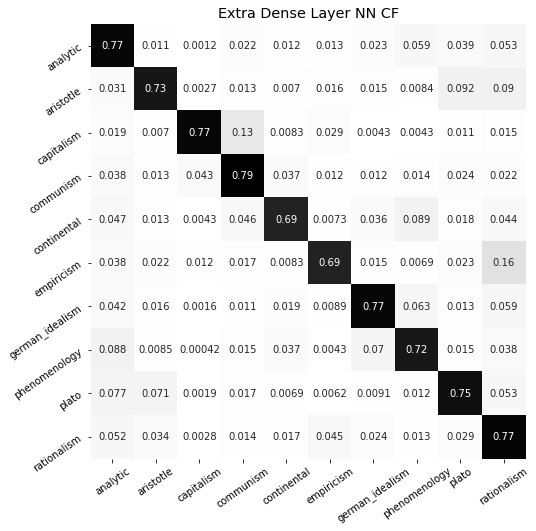




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     13520
           1       0.85      0.73      0.78     12629
           2       0.90      0.77      0.83      4598
           3       0.63      0.79      0.70      4422
           4       0.84      0.69      0.76      8633
           5       0.77      0.69      0.73      5181
           6       0.83      0.77      0.80     10429
           7       0.66      0.72      0.69      7170
           8       0.74      0.75      0.74      9552
           9       0.49      0.77      0.60      5678

    accuracy                           0.74     81812
   macro avg       0.75      0.74      0.74     81812
weighted avg       0.76      0.74      0.75     81812



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_dense_history, test, preds, labels=flipped_dict, title='Extra Dense Layer NN CF')

This one's accuracy was still inching up even at the end of 10 epochs. Perhaps it could benefit from longer training. 

#### Changing the Batch Size

First, the baseline model but with double the batch size.

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         10057472  
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                260       
Total params: 10,094,807
Trainable params: 10,094,807
Non-trainable params: 0
_________________________________________________________________


None

In [ ]:
more_batches_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
381/381 [==============================] - 49s 125ms/step - loss: 1.9629 - accuracy: 0.2569 - val_loss: 1.0991 - val_accuracy: 0.6390
Epoch 2/10
381/381 [==============================] - 47s 123ms/step - loss: 1.0973 - accuracy: 0.6341 - val_loss: 0.8936 - val_accuracy: 0.7165
Epoch 3/10
381/381 [==============================] - 47s 124ms/step - loss: 0.8314 - accuracy: 0.7344 - val_loss: 0.7972 - val_accuracy: 0.7531
Epoch 4/10
381/381 [==============================] - 47s 123ms/step - loss: 0.6965 - accuracy: 0.7783 - val_loss: 0.8022 - val_accuracy: 0.7548
Epoch 5/10
381/381 [==============================] - 47s 123ms/step - loss: 0.5956 - accuracy: 0.8093 - val_loss: 0.8379 - val_accuracy: 0.7533
Epoch 6/10
381/381 [==============================] - 47s 125ms/step - loss: 0.5509 - accuracy: 0.8223 - val_loss: 0.8378 - val_accuracy: 0.7644
Epoch 7/10
381/381 [==============================] - 47s 124ms/step - loss: 0.5162 - accuracy: 0.8335 - val_loss: 0.8560 - val_ac

Not any real improvement here.

Next let's try the same but with an additional dense layer.

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         10049920  
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

None

In [ ]:
more_batches_more_dense_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
381/381 [==============================] - 49s 125ms/step - loss: 2.1549 - accuracy: 0.1860 - val_loss: 1.5261 - val_accuracy: 0.4664
Epoch 2/10
381/381 [==============================] - 47s 124ms/step - loss: 1.5431 - accuracy: 0.4294 - val_loss: 1.2246 - val_accuracy: 0.5868
Epoch 3/10
381/381 [==============================] - 47s 124ms/step - loss: 1.2616 - accuracy: 0.5383 - val_loss: 1.0969 - val_accuracy: 0.6455
Epoch 4/10
381/381 [==============================] - 47s 124ms/step - loss: 1.1155 - accuracy: 0.6036 - val_loss: 1.0276 - val_accuracy: 0.6855
Epoch 5/10
381/381 [==============================] - 47s 124ms/step - loss: 1.0092 - accuracy: 0.6480 - val_loss: 1.0163 - val_accuracy: 0.7011
Epoch 6/10
381/381 [==============================] - 48s 125ms/step - loss: 0.9199 - accuracy: 0.6839 - val_loss: 1.0384 - val_accuracy: 0.6963
Epoch 7/10
381/381 [==============================] - 47s 124ms/step - loss: 0.8713 - accuracy: 0.7021 - val_loss: 1.0231 - val_ac

Not much luck there either. Now we get extra experimental.

#### A Bit of Everything!

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# two dense layers, an LSTM layer, and a bi-directional layer!
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         10850176  
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
dense_10 (Dense)             (None, None, 25)          1275      
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 25)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               30400     
_________________________________________________________________
dense_11 (Dense)             (None, 25)                2525      
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)               

None

In [ ]:
LSTM_bi_dense_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
380/380 [==============================] - 96s 237ms/step - loss: 2.0263 - accuracy: 0.2269 - val_loss: 1.2184 - val_accuracy: 0.5927
Epoch 2/10
115/380 [========>.....................] - ETA: 57s - loss: 1.2279 - accuracy: 0.5676

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(LSTM_bi_dense_history, test, preds, labels=flipped_dict, title='LSTM 2 Dense & Bi-Directional NN CF')

These results were again in the range of the rest. At this point it's clear that we can achieve about 75% accuracy with most types of models; we're looking for something that can jump us up to 80% or more.

Let's try extra dense layers, this time with three of them. 

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# three dense layers on top of an LSTM layer
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(75, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         10071296  
_________________________________________________________________
lstm_5 (LSTM)                (None, 75)                61200     
_________________________________________________________________
dense_11 (Dense)             (None, 25)                1900      
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 25)               

None

In [ ]:
# extra epochs since the last extra dense layer model seemed to improve for longer
triple_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
767/767 [==============================] - 81s 104ms/step - loss: 2.0810 - accuracy: 0.1759 - val_loss: 1.5213 - val_accuracy: 0.3865
Epoch 2/20
767/767 [==============================] - 79s 104ms/step - loss: 1.4841 - accuracy: 0.3999 - val_loss: 1.2963 - val_accuracy: 0.5482
Epoch 3/20
767/767 [==============================] - 79s 103ms/step - loss: 1.2211 - accuracy: 0.5440 - val_loss: 1.1543 - val_accuracy: 0.6236
Epoch 4/20
767/767 [==============================] - 79s 104ms/step - loss: 1.0307 - accuracy: 0.6314 - val_loss: 1.0632 - val_accuracy: 0.6637
Epoch 5/20
767/767 [==============================] - 79s 103ms/step - loss: 0.9208 - accuracy: 0.6763 - val_loss: 1.0657 - val_accuracy: 0.6821
Epoch 6/20
767/767 [==============================] - 79s 103ms/step - loss: 0.8335 - accuracy: 0.7142 - val_loss: 1.0767 - val_accuracy: 0.6851
Epoch 7/20
767/767 [==============================] - 79s 103ms/step - loss: 0.7566 - accuracy: 0.7448 - val_loss: 1.1155 - val_ac

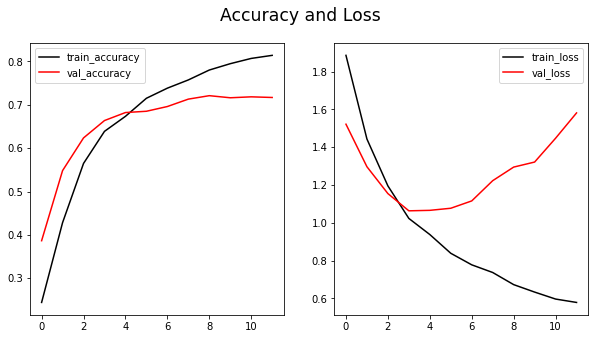

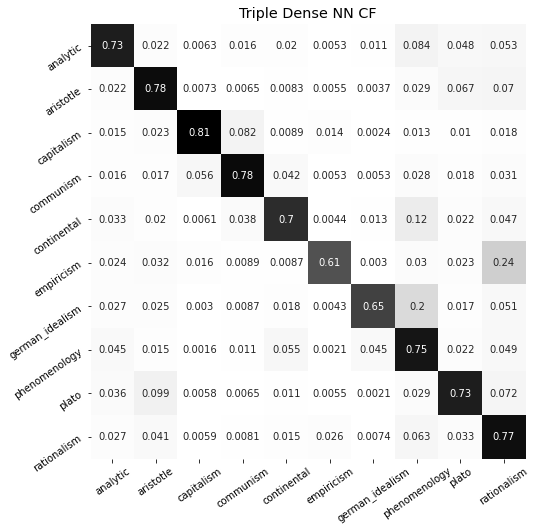




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.73      0.78     13320
           1       0.81      0.78      0.79     12613
           2       0.84      0.81      0.83      4608
           3       0.73      0.78      0.75      4504
           4       0.81      0.70      0.75      8566
           5       0.85      0.61      0.71      5061
           6       0.90      0.65      0.75     10642
           7       0.49      0.75      0.59      7095
           8       0.74      0.73      0.74      9625
           9       0.47      0.77      0.58      5778

    accuracy                           0.73     81812
   macro avg       0.75      0.73      0.73     81812
weighted avg       0.77      0.73      0.74     81812



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(triple_dense_history, test, preds, labels=flipped_dict, title='Triple Dense NN CF')

Not particularly inspiring, in fact this is worse than just two dense layers. 

We've tried a decent number of options here. Next let's see what happens if we bring in word embeddings from GloVe.

### Using Glove Word Embeddings

In [16]:
glove_file = datapath('/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.300d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

In [17]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='glove_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(glove_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          20000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
Total params: 20,021,735
Trainable params: 21,735
Non-trainable params: 20,000,000
_________________________________________________________________


None

In [18]:
glove_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 29s 35ms/step - loss: 2.2821 - accuracy: 0.1223 - val_loss: 2.1441 - val_accuracy: 0.2018
Epoch 2/20
760/760 [==============================] - 26s 35ms/step - loss: 2.1268 - accuracy: 0.1965 - val_loss: 2.0020 - val_accuracy: 0.2669
Epoch 3/20
760/760 [==============================] - 26s 35ms/step - loss: 2.0006 - accuracy: 0.2497 - val_loss: 1.9337 - val_accuracy: 0.2933
Epoch 4/20
760/760 [==============================] - 26s 35ms/step - loss: 1.9280 - accuracy: 0.2780 - val_loss: 1.8772 - val_accuracy: 0.3182
Epoch 5/20
760/760 [==============================] - 26s 35ms/step - loss: 1.8686 - accuracy: 0.3038 - val_loss: 1.8371 - val_accuracy: 0.3232
Epoch 6/20
760/760 [==============================] - 26s 34ms/step - loss: 1.8166 - accuracy: 0.3210 - val_loss: 1.7941 - val_accuracy: 0.3459
Epoch 7/20
760/760 [==============================] - 26s 35ms/step - loss: 1.7888 - accuracy: 0.3332 - val_loss: 1.7685 - val_accuracy:

Not very promising - perhaps the vectors that worked from GloVe and were trained on our data would be better?

### Custom Word Embeddings

In [19]:
custom_vectors = KeyedVectors.load('/gdrive/MyDrive/Colab_Projects/Phil_NLP/w2v_models/w2v_for_nn.wordvectors')

In [22]:
custom_vectors.most_similar('philosophy')

[('metaphysics', 0.7894171476364136),
 ('theology', 0.7694715261459351),
 ('religion', 0.7320282459259033),
 ('science', 0.728236734867096),
 ('philosophical', 0.7186429500579834),
 ('transcendental philosophy', 0.7153382301330566),
 ('natural science', 0.7118123769760132),
 ('psychology', 0.7090511322021484),
 ('politics', 0.6923774480819702),
 ('skepticism', 0.6838987469673157)]

In [29]:
tokenizer, x_train_seqx_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='custom_w2v_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(custom_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         8499300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                260       
Total params: 8,571,035
Trainable params: 71,735
Non-trainable params: 8,499,300
_________________________________________________________________


None

In [30]:
len(tokenizer.word_index)

84765

In [31]:
len(custom_vectors.vocab)

28331

In [32]:
custom_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10


InvalidArgumentError: ignored

Sadly, the embeddings we trained on our data (and on GloVe) seem to hinder more than they help.

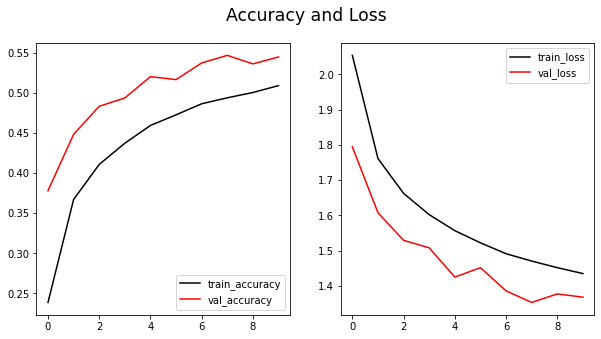

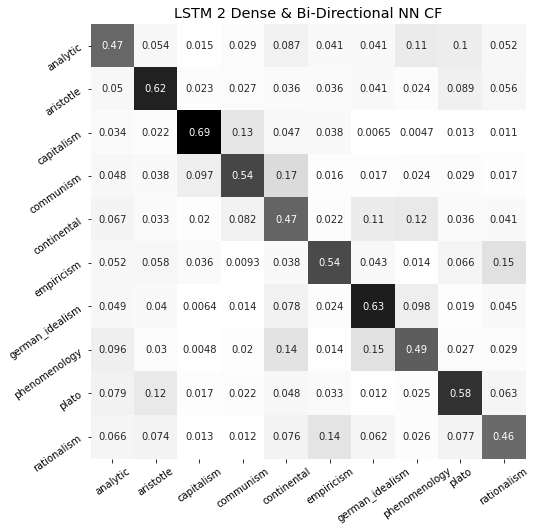




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.60      0.47      0.52     13403
           1       0.68      0.62      0.65     12702
           2       0.66      0.69      0.68      4640
           3       0.49      0.54      0.51      4601
           4       0.42      0.47      0.44      8329
           5       0.48      0.54      0.51      5062
           6       0.63      0.63      0.63     10554
           7       0.44      0.49      0.47      7140
           8       0.57      0.58      0.58      9659
           9       0.40      0.46      0.43      5722

    accuracy                           0.55     81812
   macro avg       0.54      0.55      0.54     81812
weighted avg       0.56      0.55      0.55     81812



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(custom_embeddings_LSTM_history, test, preds, labels=flipped_dict, title='Custom Embeddings LSTM NN CF')

In [ ]:
Word2Vec.load('/gdrive/MyDrive/Colab_Projects/Phil_NLP/w2v_for_nn2.bin')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: ignored

In [ ]:
print(classification_report(test, preds))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     13274
           1       0.82      0.78      0.80     12774
           2       0.83      0.80      0.81      4536
           3       0.69      0.79      0.73      4451
           4       0.80      0.74      0.77      8466
           5       0.71      0.77      0.74      5152
           6       0.83      0.77      0.80     10554
           7       0.70      0.75      0.72      7159
           8       0.71      0.80      0.75      9589
           9       0.68      0.71      0.70      5857

    accuracy                           0.77     81812
   macro avg       0.76      0.77      0.76     81812
weighted avg       0.77      0.77      0.77     81812



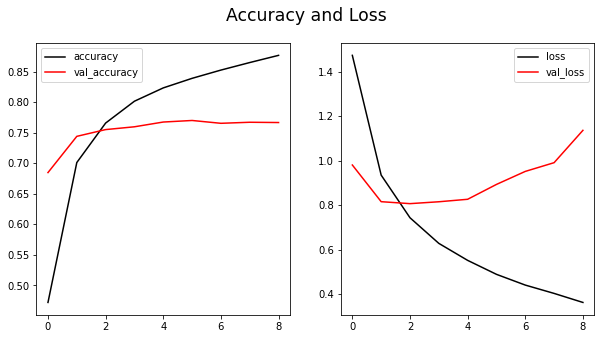

In [ ]:
def show_curves_nn(model):
  history_df = pd.DataFrame(model.history)
  fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
  fig.suptitle('Accuracy and Loss', fontsize='xx-large')
  ax1.plot(history_df['accuracy'], label='accuracy', color='black')
  ax1.plot(history_df['val_accuracy'], label='val_accuracy', color='red')
  legend = ax1.legend()
  ax2.plot(history_df['loss'], label='loss', color='black')
  ax2.plot(history_df['val_loss'], label='val_loss', color='red')
  legend = ax2.legend()

show_curves_nn(history)

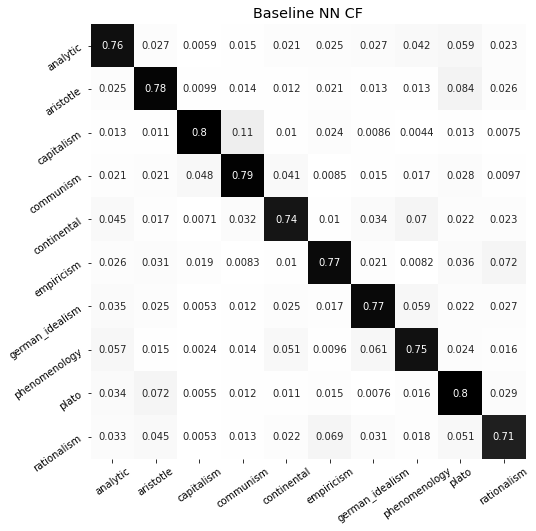

In [ ]:
plot_pretty_nn_cf(test, preds, label_dict=flipped_dict, title='Baseline NN CF')

In [ ]:
def plot_pretty_nn_cf(test_labels, predicted_labels, cmap='Greys', label_dict={}, title='CF'):
  fig, ax = plt.subplots(figsize=(8,8))
  cm = confusion_matrix(test_labels, predicted_labels)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm, cmap=cmap, annot=True, cbar=False, square=True)
  if label_dict != {}:
    ax.set_xticklabels([label_dict[int(x.get_text())] for x in ax.get_xticklabels()], rotation=35)
    ax.set_yticklabels([label_dict[int(x.get_text())] for x in ax.get_yticklabels()], rotation=35)
  ax.set_title(title, fontsize='x-large')
  plt.show()